In [2]:
!pip install timm watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00


In [3]:
from IPython.display import HTML
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
import cv2
import torch
import matplotlib.pyplot as plt

In [4]:
import watermark

%reload_ext watermark
%watermark -a "Version 0" --iversions

Author: Version 0

matplotlib: 3.7.1
torch     : 2.1.0+cu121
PIL       : 9.4.0
watermark : 2.4.3
numpy     : 1.23.5
cv2       : 4.8.0



In [5]:
VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: { deviceId: 1 } })
  .then(stream => video.srcObject = stream)

var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    var ctx = canvas.getContext('2d');
    ctx.drawImage(video, 0, 0, w, h);
    var imageData = ctx.getImageData(0, 0, w, h);
    var dataUrl = canvas.toDataURL('image/jpeg', %f);

    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(dataUrl);
  }
})
</script>
"""

In [6]:
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = transforms.small_transform

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Loading weights:  None


/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.

In [7]:
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0], size[1], quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  img = np.asarray(Image.open(f))

  return img

# Capture a photo using the webcam with deviceId 1
img = take_photo()

In [8]:
imgbatch = transform(img).to(device)


In [9]:
with torch.no_grad():
    imgbatch = imgbatch.to(device)
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

    output = prediction.cpu().numpy()

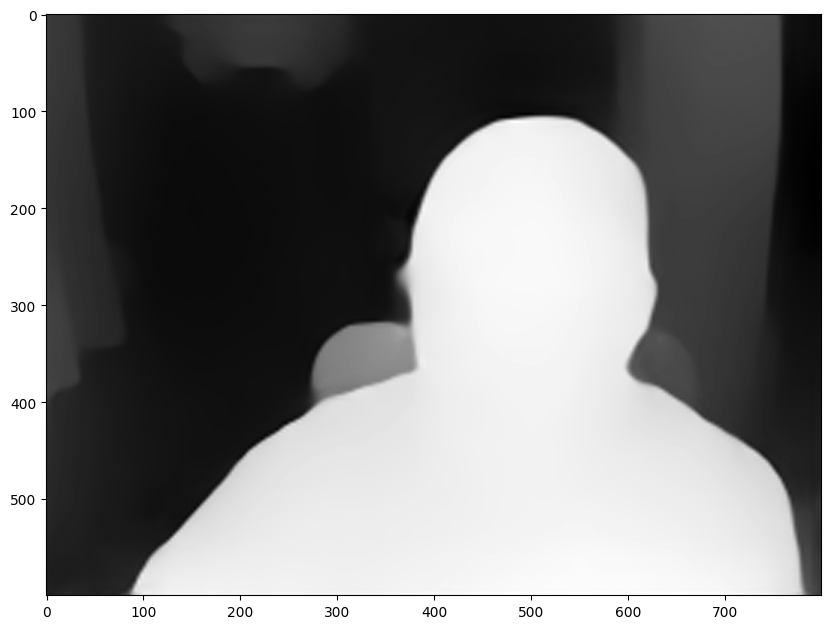

In [10]:
# Display the captured photo in grayscale
plt.figure(figsize=(10,10))
plt.imshow(output, cmap='gray')
plt.show()

In [15]:
mask = output >= 150
mask = cv2.resize((mask * 255).astype('uint8'), (output.shape[1], output.shape[0]))
filtered_near = output.copy()
# filtered_near[mask == 0] = [0, 0, 0]

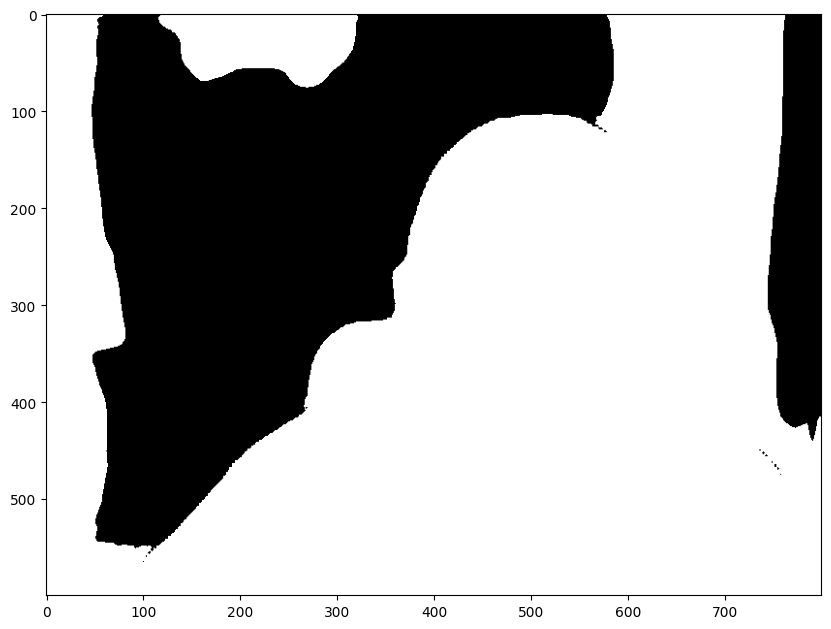

In [16]:
# Display the captured photo in grayscale
plt.figure(figsize=(10,10))
plt.imshow(mask, cmap='gray')
plt.show()